# Elementary arithmetic operations
In this tutorial, we are going to provide a construction of quantum networks effecting basic arithmetic operations, covering from addition to modular exponentiation, providing some executable examples using the simulator and five qubit device (ibmqx2).

\begin{align}
Plain\; addition \rightarrow Modular\; addition \rightarrow Modular\; multiplication \rightarrow Modular\; exponentiation
\end{align}

### Contributors

Carlos Bravo Prieto

## Introduction
Nowadays, there is no known efficient classical algorithm for factoring. In the past years, the mathematician and MIT professor Peter Shor discovered an efficient algorithm for factoring large numbers using quantum effects, showing the potential power of quantum computation. 
There is a lot of interest in an efficient factoring algorithm, because most of the modern encryption is based on the impossibility to factorize large numbers. Therefore, Shor's algorithm could represent the fall of the actual cryptography.

Shor's algorithm uses the quantum fourier transform to find the order $r$ of a randomly chosen number $x$ in the multiplicative group. This is done by exponentiating $x$ modulo $N$. Here, we focus in the quantum modular exponentiation which seems to be the most difficult part. Although the quantum modular exponentiation does not represent any speed up respect their classical analog, it has to be done in order to implement the quantum Shor's algorithm.

## Plain addition
Our first step is to build the most basic operation, the plain addition, which can be written as

\begin{align}
|a, b \rangle \, \rightarrow \, |a, a+b \rangle \,.
\end{align}

To prevent overflows, if $a$ and $b$ are encoded in $n$ qubits, the second register must be of size $n+1$. We will provisionally write the carries of the addition in a temporary register of size $n-1$ initially in state $|0\rangle$. The operation of the plain addition can be understood as:
1. First we compute the most significant bit of the result $a + b$. We have to compute all the carries $c_i$ through
the relation $c_i$ $\leftarrow$ $a_i$ AND $b_i$ AND $c_{i−1}$, where $a_i$, $b_i$ and $c_i$ represent the $i$th qubit of the first, second and temporary register respectively.
2. Finally we reverse all these operations, except for the last one which computed the leading bit of the
result. This way we can reuse the same temporary register if we require repeated additions. Meanwhile we are doing the resetting process, the other qubits of the result are computed through the relation $b_i$ $\leftarrow$ $a_i$ XOR $b_i$ XOR $c_{i−1}$.

The total number of qubits needed is $3n$.

![Plain_addition network](plain_addition_network1.png)

With this figure we seek a generalization of the algorithm, but the first carry qubit $c_0$ is not really needed, because the value will always be $0$.

### Implementation in ibmqx2. Example 1.
We are going to start with the easiest example, the implementation of the plain addition of two one-qubit numbers $a$ and $b$. This program can be executed in ibmqx2 (5 qubits).

In [1]:
# checking the version of PYTHON; only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# importing QISKit
from qiskit import QuantumProgram

import sys

sys.path.append("../../../")

import Qconfig  

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.qcvv.tomography import marginal_counts
from qiskit import available_backends, register


# create a QuantumProgram object instance.
q_program = QuantumProgram()
register(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

print(available_backends())
# backend
#backend = 'ibmqx2'  
#backend = 'local_qasm_simulator'
backend = "ibmq_qasm_simulator"

['ibmq_16_rueschlikon', 'ibmq_5_tenerife', 'ibmq_5_yorktown', 'ibmq_qasm_simulator', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


First let's define the plain addition algorithm for two one-qubit numbers $a$ and $b$. We implement the quantum plain addition algorithm based on the previous figure. We also define a function that creates those initial states (assuming that our input in QISKIT code is integer). We have to build the Toffoli gate from the elementary gates of the quantum computer.

In [2]:
# quantum plain addition algorithm for 1-qubit numbers    
def addition_1bit(circuit, q):
    circuit.h(q[2])
    circuit.cx(q[1], q[2])
    circuit.tdg(q[2])
    circuit.cx(q[0], q[2])
    circuit.t(q[2])
    circuit.cx(q[1], q[2])
    circuit.tdg(q[2])
    circuit.cx(q[0], q[2])
    circuit.t(q[2])
    circuit.h(q[2])
    circuit.t(q[1])
    circuit.cx(q[0], q[1])
    circuit.t(q[0])
    circuit.tdg(q[1])
    
# n-qubit number input state
def number_state(circuit, q, a, b):
    if a == 1:
        circuit.x(q[0]) # q[0] contains the value of a
    if b == 1:
        circuit.x(q[1]) # q[1] contain the value of b

Let's now implement the plain addition of two one-qubit numbers $a+b$, for instance $1+1$, that should return $2 \,(10)$.

In the Quantum Experience composer this circuit would look like:

![Composer_circuit_1+1](1+1.png)

COMPLETED
{'creg_labels': 'cr[2]', 'additionalData': {'seed': 736229585}, 'time': 0.216227, 'counts': {'10': 1024}, 'date': '2018-07-18T04:46:03.463Z'}


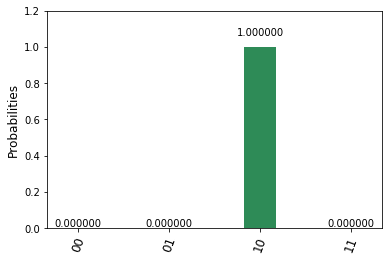

Backend: ibmq_qasm_simulator
Highest probability outcome: 2


In [3]:
# we define the values (0 or 1)
a = 1                 
b = 1

# one single quantum register which contains 'a' (1 qubit) and 'b' (2 qubits)
q = q_program.create_quantum_register("q", 3) # 3 qubits
# clasical register
c = q_program.create_classical_register("cr", 2) # 2 bits

# quantum circuit involving the quantum register and the classical register
add1bit_circuit = q_program.create_circuit("add", [q] ,[c])

# create the state containing a and b
number_state(add1bit_circuit, q, a, b)

# addition
addition_1bit(add1bit_circuit, q)

# measurements to see the result, which has been written in b (q[1]q[2])
add1bit_circuit.measure(q[1], c[0])
add1bit_circuit.measure(q[2], c[1])

# compile and execute the quantum program in the backend
result = q_program.execute(["add"], backend=backend, shots=1024, max_credits=3, timeout=999999)

# show the results
print(result)
print(result.get_data("add"))
counts = marginal_counts(result.get_counts("add"), [0, 1])
plot_histogram(counts)
print("Backend:", backend)
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

We see that the highest probability outcome is $2 \;(10)$ when we execute the code on ibmqx2.

### Implementation in the quantum simulator. Example 2.
The second example is the implementation of the plain addition of two $n$-qubit numbers $a$ and $b$. This program can be executed in the quantum simulator.

In [4]:
# checking the version of PYTHON; only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# importing QISKit
from qiskit import QuantumProgram

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram

# create a QuantumProgram object instance.
q_program = QuantumProgram()

# backend
backend = 'ibmq_qasm_simulator'

First let's define different modules that we are going to use repeatedly, as well as the plain addition algorithm for two $n$-qubit numbers.

In [5]:
def carry(circuit, q0, q1, q2, q3):
    "carry module"
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def carry_inv(circuit, q0, q1, q2, q3):
    "carry module but running backwards"
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summation(circuit, q0, q1, q2):
    "summation module"
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)
    
# quantum plain addition algorithm for n-qubit numbers    
def addition_nbit(circuit, qa, qb, qcar, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
        carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summation(circuit, qcar[i-1], qa[i], qb[i])
            carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1])
        summation(circuit, qcar[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])

Now we are going to define a function that creates the states containing $a$ and $b$. 

In [6]:
# n-qubit number input state
def number_state(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])

Let's now implement the plain addition of two numbers $a+b$, for instance $9+14$, that should return $23$ $(10111)$:

COMPLETED
{'creg_labels': 'cr[5]', 'additionalData': {'seed': 769201819}, 'time': 3.83771, 'counts': {'10111': 1024}, 'date': '2018-07-18T04:46:17.076Z'}


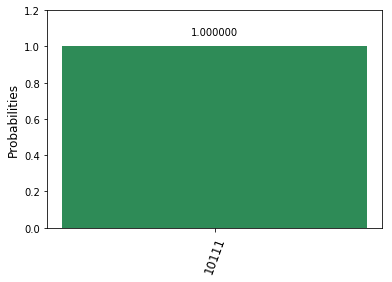

Backend: ibmq_qasm_simulator
Highest probability outcome: 23


In [7]:
# we define the values
a = 9                 
b = 14

# computing the number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(b))
if n2 > n:
    n = n2
    
# classical register with n+1 bits.
c = q_program.create_classical_register("cr", n+1)
# quantum registers
qa = q_program.create_quantum_register("qa", n) # a qubits
qb = q_program.create_quantum_register("qb", n+1) # b qubits
# if n = 1, no need of carry register 
if n == 1:
    qcar = 0
    # quantum circuit involving the quantum registers and the classical register
    addnbit_circuit = q_program.create_circuit("add", [qa, qb],[c])
else:
    qcar = q_program.create_quantum_register("qcar", n-1) # carry qubits
    # quantum circuit involving the quantum registers and the classical register
    addnbit_circuit = q_program.create_circuit("add", [qa, qb, qcar],[c])

# create the state containing a
number_state(addnbit_circuit, qa, a, n)
# create the state containing b
number_state(addnbit_circuit, qb, b, n)

# addition
addition_nbit(addnbit_circuit, qa, qb, qcar, n)

# measurements to see the result
for i in range(n+1):
    addnbit_circuit.measure(qb[i], c[i])

# compile and execute the quantum program in the backend
result = q_program.execute(["add"], backend=backend, shots=1024, timeout=999999)

# show the results.
print(result)
print(result.get_data("add"))
counts = result.get_counts("add")
plot_histogram(counts)
print("Backend:", backend)
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

We indeed see that the only appearing outcome is $23\,(10111)$ when we execute the code on local_qasm_simulator.

## Modular addition
As you may already expect, as we increase the complexity of the arithmetic operations we also increase the complexity of the circuit network. Our next goal is to build a network that effects

\begin{align}
| a, b \rangle\, \rightarrow \, | a, a+b\, mod \,N \rangle
\end{align}

where $a+b < 2N$ (this condition is enough in order to build the following arithmetic operations). The approach consists essentially on taking the output of the plain adder network and then substracting $N$, depending on whether the value $a+b$ is bigger or smaller than $N$. In order to do so, we use a temporary qubit which indicates whether there has been an overflow in the substraction or not, and adding back $N$ depending on this. The last part of the network takes care of reseting every register (except the second register which contains the result) to its initial state.

The total number of qubits needed is $5n + 2$.

![Modular addition network](modular_addition_network1.png)

### Implementation in the quantum simulator. Example 3.
The third example is the implementation of the modular addition of two $n$-qubit numbers $a$ and $b$ (modulo $N$). This program can be executed in the quantum simulator.

In [8]:
# checking the version of PYTHON; only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# importing QISKit
from qiskit import QuantumProgram

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram

# create a QuantumProgram object instance.
q_program = QuantumProgram()

# backend
backend = 'ibmq_qasm_simulator'

Now we define again the different modules that we are going to use repeatedly, as well as the modular addition algorithm for two $n$-qubit numbers. This time we also have to substract or use conditional adders (in order to substract $N$ or not), therefore we have to implement new modules such as the conditional plain addition or the plain substraction.

In [9]:
def carry(circuit, q0, q1, q2, q3):
    "carry module"
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def carry_inv(circuit, q0, q1, q2, q3):
    "carry module running backwards"
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summation(circuit, q0, q1, q2):
    "summation module"
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)
    
def summation_inv(circuit, q0, q1, q2):
    "summation module running backwards"
    circuit.cx(q0, q2)
    circuit.cx(q1, q2)

# quantum plain addition algorithm for n-qubit numbers    
def addition_nbit(circuit, qa, qb, qcar, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
        carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summation(circuit, qcar[i-1], qa[i], qb[i])
            carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1])
        summation(circuit, qcar[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
    
# quantum plain substraction algorithm for n-qubit numbers
def subs_nbit(circuit, qa, qb, qcar, n):
    "same circuit as the plain addition but going backwards"
    if n == 1:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qb[1])
    else:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        summation_inv(circuit, qcar[0], qa[1], qb[1])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
            summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2])
        circuit.cx(qa[n-1], qb[n-1])
        carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        for i in range(n-2, 0, -1):
            carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i])
        circuit.cx(qa[0], qb[0])  
        circuit.ccx(qa[0], qb[0], qcar[0])

def cond_toffoli(circuit, qcond, q1, q2, q3):
    "toffoli gate conditioned by an external qubit"
    circuit.h(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.h(q3)
    circuit.t(q2)
    circuit.ccx(qcond, q1, q2)
    circuit.t(q1)
    circuit.tdg(q2)
    circuit.ccx(qcond, q1, q2)
    
def cond_carry(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module"
    cond_toffoli(circuit, qcond, q1, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q0, q2, q3)
    
def cond_carry_inv(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module running backwards"
    cond_toffoli(circuit, qcond, q0, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q1, q2, q3)
    
def cond_summation(circuit, q0, q1, q2, qcond):
    "conditional summation module"
    circuit.ccx(qcond, q1, q2)
    circuit.ccx(qcond, q0, q2)
    
def cond_summation_inv(circuit, q0, q1, q2, qcond):
    "conditional summation module running backwards"
    circuit.ccx(qcond, q0, q2)
    circuit.ccx(qcond, q1, q2)
    
# quantum conditional plain addition algorithm for n-qubit numbers    
def cond_addition_nbit(circuit, qa, qb, qcar, qcond, n):
    "plain addition algorithm conditioned by an external qubit"
    if n == 1:
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qb[1])
        circuit.ccx(qcond[0], qa[0], qb[0])
    else:
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qcar[0])
        circuit.ccx(qcond[0], qa[0], qb[0])
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond[0])
        cond_carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond[0])
        circuit.ccx(qcond[0], qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            cond_summation(circuit, qcar[i-1], qa[i], qb[i], qcond[0])
            cond_carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1], qcond[0])
        cond_summation(circuit, qcar[0], qa[1], qb[1], qcond[0])
        circuit.ccx(qcond[0], qa[0], qb[0])
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qcar[0])
        circuit.ccx(qcond[0], qa[0], qb[0])

# quantum conditional plain substraction algorithm for n-qubit numbers      
def cond_subs_nbit(circuit, qa, qb, qcar, qcond, n):
    "same circuit as the conditional plain addition but going backwards"
    if n == 1:
        circuit.ccx(qcond[0], qa[0], qb[0])
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qb[1])
    else:
        circuit.ccx(qcond[0], qa[0], qb[0])
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qcar[0])
        circuit.ccx(qcond[0], qa[0], qb[0])
        cond_summation_inv(circuit, qcar[0], qa[1], qb[1], qcond[0])
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond[0])
            cond_summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2], qcond[0])
        circuit.ccx(qcond[0], qa[n-1], qb[n-1])
        cond_carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond[0])
        for i in range(n-2, 0, -1):
            cond_carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i], qcond[0])
        circuit.ccx(qcond[0], qa[0], qb[0])  
        cond_toffoli(circuit, qcond[0], qa[0], qb[0], qcar[0])
        
# quantum modular addition algorithm for n-qubit numbers 
def mod_addition_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, n):
    addition_nbit(circuit, qa, qb, qcar, n)
    subs_nbit(circuit, qN, qb, qcar, n)
    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp[0])
    circuit.x(qb[n])
    cond_subs_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    addition_nbit(circuit, qN, qb, qcar, n)
    cond_addition_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    subs_nbit(circuit, qa, qb, qcar, n)
    circuit.cx(qb[n], qtemp[0])
    addition_nbit(circuit, qa, qb, qcar, n)

Now we define the function that creates the states containing $a$, $b$ and $N$. 

In [10]:
# n-qubit number input state
def number_state(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])

Let's implement the modular addition of two numbers $a+b \, mod \, N$, for instance $2+3 \,mod\, 3$, that should return $2 \, (010)$:

COMPLETED
{'creg_labels': 'cr[3]', 'additionalData': {'seed': 258325416}, 'time': 43.8285, 'counts': {'010': 1024}, 'date': '2018-07-18T04:47:11.590Z'}


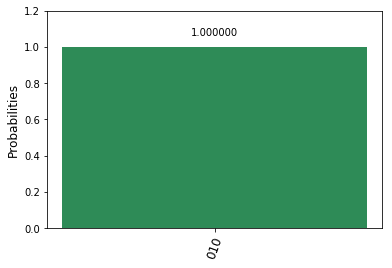

Backend: ibmq_qasm_simulator
Highest probability outcome: 2


In [11]:
# we define the values
a = 2
b = 3                     
N = 3

# computing number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(b))
n3 = len("{0:b}".format(N))
if n2 > n:
    n = n2
if n3 > n:
    n = n3
    
# classical register with n+1 bits.
c = q_program.create_classical_register("cr", n+1)
# quantum registers
qa = q_program.create_quantum_register("qa", n) # a qubits
qb = q_program.create_quantum_register("qb", n+1) # b qubits
qN = q_program.create_quantum_register("qN", n+1) # N qubits
qNtemp = q_program.create_quantum_register("qNtemp", n) # temporary N qubits
qtemp = q_program.create_quantum_register("qtemp", 1) # temporary qubit
# if n = 1, no need of carry register 
if n == 1:
    qcar = 0
    # quantum circuit involving the quantum registers and the classical register
    mod_add_circuit = q_program.create_circuit("mod_add", [qa, qb, qN, qNtemp, qtemp],[c])
else:
    qcar = q_program.create_quantum_register("qcar", n-1) # carry qubits
    # quantum circuit involving the quantum registers and the classical register
    mod_add_circuit = q_program.create_circuit("mod_add", [qa, qb, qN, qcar, qNtemp, qtemp],[c])

# create the state containing 'a'
number_state(mod_add_circuit, qa, a, n)
# create the state containing 'b'
number_state(mod_add_circuit, qb, b, n)
# create the state containing 'N'
number_state(mod_add_circuit, qN, N, n)
# create the temporary state containing 'N'
number_state(mod_add_circuit, qNtemp, N, n)

# modular addition
mod_addition_nbit(mod_add_circuit, qa, qb, qN, qNtemp, qcar, qtemp, n)

# measurements to see the result
for i in range(n+1):
    mod_add_circuit.measure(qb[i], c[i])

# compile and execute the quantum program in the backend
result = q_program.execute(["mod_add"], backend=backend, shots=1024, max_credits=3)

# show the results.
print(result)
print(result.get_data("mod_add"))
counts = result.get_counts("mod_add")
plot_histogram(counts)
print("Backend:", backend)
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

Indeed the result is what we were expecting, $2\, (010)$.

## Controlled modular multiplication
The modular multiplication can be implemented by repeated conditional additions modulo $N$: $ax = 2^0 ax_0 + 2^1 ax_1 + ... + 2^{n-1} ax_{n-1}$. We start from a register initiated in the state $|0\rangle$. Then, the network consists in adding conditionally the value $2^i a$, depending on the state of the qubit $|x_i\rangle$. Anyway, in order to implement the modular exponentiation, we need a more slightly complicated circuit, by the fact that we want the multiplication be effected conditionally depeding on the value of some external qubit $|c\rangle$. If $|c\rangle = |1\rangle$

\begin{align}
|c; x,0\rangle \, \rightarrow \,  |c;x, a \times x\; mod\, N\rangle 
\end{align}

This is done by applying Toffoli gates to $|x_i\rangle$ and control qubits $|c\rangle$ and the corresponding target qubit. The resetting of the register to its initial state is done by appliying the same Toffoli gates again. If the control qubit is $|0\rangle$, no operations are done, giving the state $|c; x,0\rangle$. Since we want the state to be $|c;x,x\rangle$ we copy the values of the input register to the result register. This is done in the final part of the network. 

![Modular multiplication network](modular_multiplication_network1.png)

However, this circuit requires that the value to be multiplied $a$ be hardwired into the circuit.

\begin{align}
a \times x = (a_{n-1} 2^{n-1} + ... + a_0 2^0)\times (x_{n-1} 2^{n-1} + ... + x_0 2^0) = 2^{2n-2}(a_{n-1} x_{n-1}) + ...+ 2^{n-1}(a_0 x_{n-1} + a_1 x_{n-2} + .... + a_{n-2} x_1 + a_{n-1} x_0) + ... + 2^0 (a_0 x_0).
\end{align}

Notice that the indices of each pair of qubits $a_i x_j$ indicate the respective power of $2$ ($2^{i+j}$). It is important to notice that $2^{i+j}$ can exceed our modulus N. Thus, we classicaly compute this value at each step and create a temporary register to hold these values.

Summarizing, the controlled multiplication proceed as follows:
1. We begin with $n$-qubits inputs $a$ and $x$ and examine each qubit individually. We apply a three-Toffoli gate to the qubits $a_i$ and $x_j$. If both qubits along with the control qubit are $|1\rangle$ we XOR the incoming value $2^{i+j} \, mod \, N$ to the temporary register.
2. The result is then fed into an addition modulo N module which adds the result to the register holding a running total. After this, the temporary register is set to $|0\rangle$.

The total number of qubits needed is $7n + 3$.


### Implementation in the quantum simulator. Example 4.

The fourth example is the implementation of the controlled modular multiplication of two $n$-qubit numbers $a$ and $x$. This program can be executed in the quantum simulator.


In [12]:
# checking the version of PYTHON; only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# importing QISKit
from qiskit import QuantumProgram

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram
 
# create a QuantumProgram object instance.
q_program = QuantumProgram()

# backend
backend = 'ibmq_qasm_simulator'

We define the same modules as in the modular addition, as well as the controlled modular multiplication algorithm for $n$-qubit numbers.

In [13]:
def carry(circuit, q0, q1, q2, q3):
    "carry module"
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def carry_inv(circuit, q0, q1, q2, q3):
    "carry module running backwards"
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summation(circuit, q0, q1, q2):
    "summation module"
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)
    
def summation_inv(circuit, q0, q1, q2):
    "summation module running backwards"
    circuit.cx(q0, q2)
    circuit.cx(q1, q2)

# quantum plain addition algorithm for n-qubit numbers    
def addition_nbit(circuit, qa, qb, qcar, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
        carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summation(circuit, qcar[i-1], qa[i], qb[i])
            carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1])
        summation(circuit, qcar[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
    
# quantum plain substraction algorithm for n-qubit numbers
def subs_nbit(circuit, qa, qb, qcar, n):
    "same circuit as the addition but going backwards"
    if n == 1:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qb[1])
    else:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        summation_inv(circuit, qcar[0], qa[1], qb[1])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
            summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2])
        circuit.cx(qa[n-1], qb[n-1])
        carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        for i in range(n-2, 0, -1):
            carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i])
        circuit.cx(qa[0], qb[0])  
        circuit.ccx(qa[0], qb[0], qcar[0])

def cond_toffoli(circuit, qcond, q1, q2, q3):
    "toffoli gate conditioned by an external qubit"
    circuit.h(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.h(q3)
    circuit.t(q2)
    circuit.ccx(qcond, q1, q2)
    circuit.t(q1)
    circuit.tdg(q2)
    circuit.ccx(qcond, q1, q2)
    
def cond_carry(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module"
    cond_toffoli(circuit, qcond, q1, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q0, q2, q3)
    
def cond_carry_inv(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module running backwards"
    cond_toffoli(circuit, qcond, q0, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q1, q2, q3)
    
def cond_summation(circuit, q0, q1, q2, qcond):
    "conditional summation module"
    circuit.ccx(qcond, q1, q2)
    circuit.ccx(qcond, q0, q2)
    
def cond_summation_inv(circuit, q0, q1, q2, qcond):
    "conditional summation module running backwards"
    circuit.ccx(qcond, q0, q2)
    circuit.ccx(qcond, q1, q2)
    
# quantum conditional plain addition algorithm for n-qubit numbers    
def cond_addition_nbit(circuit, qa, qb, qcar, qcond, n):
    if n == 1:
        cond_toffoli(circuit, qcond, qa[0], qb[0], qb[1])
        circuit.ccx(qcond, qa[0], qb[0])
    else:
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond)
        cond_carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond)
        circuit.ccx(qcond, qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            cond_summation(circuit, qcar[i-1], qa[i], qb[i], qcond)
            cond_carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1], qcond)
        cond_summation(circuit, qcar[0], qa[1], qb[1], qcond)
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])

# quantum conditional plain substraction algorithm for n-qubit numbers      
def cond_subs_nbit(circuit, qa, qb, qcar, qcond, n):
    "same circuit as the conditional plain addition but going backwards"
    if n == 1:
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qb[1])
    else:
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])
        cond_summation_inv(circuit, qcar[0], qa[1], qb[1], qcond)
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond)
            cond_summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2], qcond)
        circuit.ccx(qcond, qa[n-1], qb[n-1])
        cond_carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond)
        for i in range(n-2, 0, -1):
            cond_carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i], qcond)
        circuit.ccx(qcond, qa[0], qb[0])  
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        
# quantum modular addition algorithm for n-qubit numbers 
def mod_addition_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, n):
    addition_nbit(circuit, qa, qb, qcar, n)
    subs_nbit(circuit, qN, qb, qcar, n)
    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp)
    circuit.x(qb[n])
    cond_subs_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    addition_nbit(circuit, qN, qb, qcar, n)
    cond_addition_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    subs_nbit(circuit, qa, qb, qcar, n)
    circuit.cx(qb[n], qtemp)
    addition_nbit(circuit, qa, qb, qcar, n)
    
# quantum controlled modular multiplication algorithm for n-qubit numbers
def cont_mod_mult_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, qX, qext, N, n):
    for i in range(n):
        for j in range(n):
            classical_mod = (2**(i+j))%N
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)
            mod_addition_nbit(circuit, qtempst, qb, qN, qNtemp, qcar, qtemp, n)
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)
    circuit.x(qext)
    cond_addition_nbit(circuit, qX, qb, qcar, qext, n)
    circuit.x(qext)

We define the function that creates the different states. This time we also define another function, what does essentially the same, but controlled by 3 control qubits. 

In [14]:
# n-qubit number input state
def number_state(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])

# n-qubit number input state, controlled by 2 control qubits
def cond_number_state(circuit, q, x, ext, control1, control2, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            cond_toffoli(circuit, ext, control1, control2, q[i])

Let's implement now the controlled modular multiplication of two numbers $a \times x \, mod \, N$, for instance $1 \times 1 \,mod\, 1$ (in order to avoid long computing times, but you can try with two-qubit numbers), that should return $0 \, (00$), if the control qubit is $|1\rangle$ (otherwise the result would be $1 \, (01)$):

COMPLETED
{'creg_labels': 'cr[2]', 'additionalData': {'seed': 2854598907}, 'time': 8.37739, 'counts': {'00': 1024}, 'date': '2018-07-18T04:47:33.428Z'}


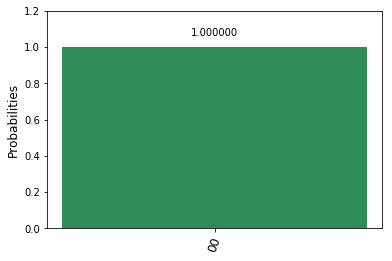

Backend: ibmq_qasm_simulator
Highest probability outcome: 0


In [15]:
# we define the values
a = 1
x = 1
N = 1


# computing number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(x))
n3 = len("{0:b}".format(N))
if n2 > n:
    n = n2
if n3 > n:
    n = n3

# classical register with n+1 bits.
c = q_program.create_classical_register("cr", n+1)
# quantum registers
qa = q_program.create_quantum_register("qa", n) # a qubits
qb = q_program.create_quantum_register("qb", n+1) # result register
qN = q_program.create_quantum_register("qN", n+1) # N qubits
qNtemp = q_program.create_quantum_register("qNtemp", n) # temporary N qubits
qtemp = q_program.create_quantum_register("qtemp", 1) # temporary qubit
qtempst = q_program.create_quantum_register("qtempst", n) # temporary register
qX = q_program.create_quantum_register("qX", n) # x register
qext = q_program.create_quantum_register("qext", 1)
# if n = 1, no need of carry register 
if n == 1:
    qcar = 0
    # quantum circuit involving the quantum registers and the classical register
    mod_mult_circuit = q_program.create_circuit("mod_mult", [qa, qb, qN, qNtemp, qtemp, qtempst, qX, qext],[c])
else:
    qcar = q_program.create_quantum_register("qcar", n-1) # carry qubits
    # quantum circuit involving the quantum register and the classical register
    mod_mult_circuit = q_program.create_circuit("mod_mult", [qa, qb, qN, qcar, qNtemp, qtemp, qtempst, qX, qext],[c])

# create the state containing 'a'
number_state(mod_mult_circuit, qa, a, n)
# create the state containing 'b'
number_state(mod_mult_circuit, qX, x, n)
# create the state containing 'N'
number_state(mod_mult_circuit, qN, N, n+1)
# create a temporary state containing 'N'
number_state(mod_mult_circuit, qNtemp, N, n)

mod_mult_circuit.x(qext[0]) # we set the control qubit to |1>

# controlled modular multiplication
cont_mod_mult_nbit(mod_mult_circuit, qa, qb, qN, qNtemp, qcar, qtemp[0], qtempst, qX, qext[0], N, n)

# measurements to see the result
for i in range(n+1):
    mod_mult_circuit.measure(qb[i], c[i])

# compile and execute the quantum program in the backend
result = q_program.execute(["mod_mult"], backend=backend, shots=1024, max_credits=3)

# show the results.
print(result)
print(result.get_data("mod_mult"))
counts = result.get_counts("mod_mult")
plot_histogram(counts)
print("Backend:", backend)
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

We indeed obtain the expected result $0 \, (00)$.

## Modular exponentiation
Using the previous constructions, we can finally implement the exponentiation modulo $N$: $a^x \,mod \,N$. The value $a^x$ can be written as $a^x = a^{2^{0}x_0} · a^{2^{1}x_1} · ... · a^{2^{m-1}x_{m-1}}$. The modular exponentiation can be implemented by initially setting a register to $|1\rangle$ and then effecting $n$ modular multiplications by $a^{2^i}$ depending on the value of the qubit $|x_i\rangle$. Let's look into the operations carefully. If $x_i = 1$:

\begin{align}
|a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}, 0 \rangle \;\rightarrow\; |a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}, a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}} · a^{2^i}\rangle 
\end{align}

otherwise, if $x_i = 0$:

\begin{align}
|a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}, 0 \rangle \;\rightarrow\; |a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}, a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}\rangle \,.
\end{align}

In both cases the result can be written as $|a^{2^{0}x_{0} + ... + 2^{i-1}x_{i-1}}, a^{2^{0}x_{0} + ... + 2^{i}x_{i}}\rangle$. We must take care about the accumulation of intermediate data. To avoid this partial information generated we run backwards a controlled multiplication network with the value $a^{-2^i} \,mod\, N$. This quantity is precomputed classically, but $a$ and $N$ must be coprimes.

The total number of qubits needed is $7n + 3 + n_x$, where $n_x$ are the number of qubits of the value $x$. 

![Modular exponentiation network](modular_exponentiation_network1.png)

### Implementation in the quantum simulator. Example 5.

As you may expect, we do not want to finish this QISKIT tutorial of basic arithmetic operations without the keystone of the Shor's factorization algorithm. The final example is the implementation of the modular exponentiation $a^x \; mod\, N$. This program can be executed in the quantum simulator.

In [16]:
# checking the version of PYTHON; only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# importing QISKit
from qiskit import QuantumProgram

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram
 
# create a QuantumProgram object instance.
q_program = QuantumProgram()

# backend
backend = 'ibmq_qasm_simulator'

This time we have to run backwards the controlled modular multiplication block, therefore we will need to define new modules such as running backwards the modular addition.

In [17]:
def carry(circuit, q0, q1, q2, q3):
    "carry module"
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def carry_inv(circuit, q0, q1, q2, q3):
    "carry module running backwards"
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summation(circuit, q0, q1, q2):
    "summation module"
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)
    
def summation_inv(circuit, q0, q1, q2):
    "summation module running backwards"
    circuit.cx(q0, q2)
    circuit.cx(q1, q2)

# quantum plain addition algorithm for n-qubit numbers    
def addition_nbit(circuit, qa, qb, qcar, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
        carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summation(circuit, qcar[i-1], qa[i], qb[i])
            carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1])
        summation(circuit, qcar[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
    
# quantum plain substraction algorithm for n-qubit numbers 
def subs_nbit(circuit, qa, qb, qcar, n):
    "same as the plain addition but running backwards"
    if n == 1:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qb[1])
    else:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        summation_inv(circuit, qcar[0], qa[1], qb[1])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
            summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2])
        circuit.cx(qa[n-1], qb[n-1])
        carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        for i in range(n-2, 0, -1):
            carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i])
        circuit.cx(qa[0], qb[0])  
        circuit.ccx(qa[0], qb[0], qcar[0])
        
def cond_toffoli(circuit, qcond, q1, q2, q3):
    "conditional toffoli gate"
    circuit.h(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.ccx(qcond, q2, q3)
    circuit.tdg(q3)
    circuit.ccx(qcond, q1, q3)
    circuit.t(q3)
    circuit.h(q3)
    circuit.t(q2)
    circuit.ccx(qcond, q1, q2)
    circuit.t(q1)
    circuit.tdg(q2)
    circuit.ccx(qcond, q1, q2)

def cond_carry(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module"
    cond_toffoli(circuit, qcond, q1, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q0, q2, q3)
    
def cond_carry_inv(circuit, q0, q1, q2, q3, qcond):
    "conditional carry module running backwards"
    cond_toffoli(circuit, qcond, q0, q2, q3)
    circuit.ccx(qcond, q1, q2)
    cond_toffoli(circuit, qcond, q1, q2, q3)
    
def cond_summation(circuit, q0, q1, q2, qcond):
    "conditional summation"
    circuit.ccx(qcond, q1, q2)
    circuit.ccx(qcond, q0, q2)
    
def cond_summation_inv(circuit, q0, q1, q2, qcond):
    "conditional summation running backwards"
    circuit.ccx(qcond, q0, q2)
    circuit.ccx(qcond, q1, q2)
    
# quantum conditional plain addition algorithm for n-qubit numbers    
def cond_addition_nbit(circuit, qa, qb, qcar, qcond, n):
    if n == 1:
        cond_toffoli(circuit, qcond, qa[0], qb[0], qb[1])
        circuit.ccx(qcond, qa[0], qb[0])
    else:
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond)
        cond_carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond)
        circuit.ccx(qcond, qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            cond_summation(circuit, qcar[i-1], qa[i], qb[i], qcond)
            cond_carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1], qcond)
        cond_summation(circuit, qcar[0], qa[1], qb[1], qcond)
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])

# quantum conditional plain substraction algorithm for n-qubit numbers      
def cond_subs_nbit(circuit, qa, qb, qcar, qcond, n):
    "same as conditional plain addition but running backwards"
    if n == 1:
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qb[1])
    else:
        circuit.ccx(qcond, qa[0], qb[0])
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        circuit.ccx(qcond, qa[0], qb[0])
        cond_summation_inv(circuit, qcar[0], qa[1], qb[1], qcond)
        for i in range(n-2):
            cond_carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1], qcond)
            cond_summation_inv(circuit, qcar[i+1], qa[i+2], qb[i+2], qcond)
        circuit.ccx(qcond, qa[n-1], qb[n-1])
        cond_carry_inv(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n], qcond)
        for i in range(n-2, 0, -1):
            cond_carry_inv(circuit, qcar[i-1], qa[i], qb[i], qcar[i], qcond)
        circuit.ccx(qcond, qa[0], qb[0])  
        cond_toffoli(circuit, qcond, qa[0], qb[0], qcar[0])
        
# quantum modular addition algorithm for n-qubit numbers 
def mod_addition_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, n):
    addition_nbit(circuit, qa, qb, qcar, n)
    subs_nbit(circuit, qN, qb, qcar, n)
    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp)
    circuit.x(qb[n])
    cond_subs_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    addition_nbit(circuit, qN, qb, qcar, n)
    cond_addition_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    subs_nbit(circuit, qa, qb, qcar, n)
    circuit.cx(qb[n], qtemp)
    addition_nbit(circuit, qa, qb, qcar, n)
    
# quantum modular substraction algorithm for n-qubit numbers
def mod_subs_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, n):
    "same as modular addition but running backwards"
    subs_nbit(circuit, qa, qb, qcar, n)
    circuit.cx(qb[n], qtemp)
    addition_nbit(circuit, qa, qb, qcar, n)
    cond_subs_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    subs_nbit(circuit, qN, qb, qcar, n)
    cond_addition_nbit(circuit, qNtemp, qN, qcar, qtemp, n)
    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp)
    circuit.x(qb[n])
    addition_nbit(circuit, qN, qb, qcar, n)
    subs_nbit(circuit, qa, qb, qcar, n)

# quantum controlled modular multiplication algorithm for n-qubit numbers
def cont_mod_mult_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, qX, qext, N, n):
    for i in range(n):
        for j in range(n):
            classical_mod = (2**(i+j))%N
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)
            mod_addition_nbit(circuit, qtempst, qb, qN, qNtemp, qcar, qtemp, n)
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)
    circuit.x(qext)
    cond_addition_nbit(circuit, qX, qb, qcar, qext, n)
    circuit.x(qext)

def cont_inv_mod_mult_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, qX, qext, N, n):
    "same as the controlled modular multiplication but running backwards"
    circuit.x(qext)
    cond_subs_nbit(circuit, qX, qb, qcar, qext, n)
    circuit.x(qext)
    for i in range(n):
        for j in range(n):
            classical_mod = (2**(i+j))%N
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)
            mod_subs_nbit(circuit, qtempst, qb, qN, qNtemp, qcar, qtemp, n)
            cond_number_state(circuit, qtempst, classical_mod, qext, qa[i], qX[j], n)

# quantum modular exponentiation algorithm for n-qubit numbers
def mod_exp_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, q1, qX, N, a, n):
    for k in range(len(qX)):
        clas_value = (a**(2**(k)))%N
        if k % 2 == 0:
            number_state(circuit, qa, clas_value, n)
            cont_mod_mult_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, q1, qX[k], N, n)
            number_state(circuit, qa, clas_value, n)
            clas_value = modinv(a**(2**(k)), N)
            number_state(circuit, qa, clas_value, n)
            cont_inv_mod_mult_nbit(circuit, qa, q1, qN, qNtemp, qcar, qtemp, qtempst, qb, qX[k], N, n)
            number_state(circuit, qa, clas_value, n)
        else:
            number_state(circuit, qa, clas_value, n)
            cont_mod_mult_nbit(circuit, qa, q1, qN, qNtemp, qcar, qtemp, qtempst, qb, qX[k], N, n)
            number_state(circuit, qa, clas_value, n)
            clas_value = modinv(a**(2**(k)), N)
            number_state(circuit, qa, clas_value, n)
            cont_inv_mod_mult_nbit(circuit, qa, qb, qN, qNtemp, qcar, qtemp, qtempst, q1, qX[k], N, n)
            number_state(circuit, qa, clas_value, n)

We define the function that creates the different states. This time we also define another two functions, which compute the value of the modular multiplicative inverse $a^{-1} \, mod \, m$. 

In [18]:
# n-qubit number input state
def number_state(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])

# n-qubit number input state, controlled by 2 control qubits
def cond_number_state(circuit, q, x, ext, control1, control2, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            cond_toffoli(circuit, ext, control1, control2, q[i])

# efficient algorithm for computing the modular multiplicative inverse a^-1 mod m
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

Let's implement now the modular exponentiation of two $n$-qubit numbers $a$ and $N$ ($a^x \, mod \, N$), for instance $1^1 \,mod\, 1$ (in order to avoid long computing times, but you can try with two-qubit numbers), that should return $0 \, (00)$:

COMPLETED
{'creg_labels': 'cr[2]', 'additionalData': {'seed': 3786959294}, 'time': 17.4706, 'counts': {'00': 1024}, 'date': '2018-07-18T04:48:04.321Z'}


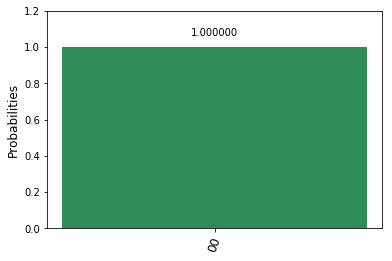

Backend: ibmq_qasm_simulator
Highest probability outcome: 0


In [19]:
# we define the values, a and N must be coprimes
a = 1
x = 1
N = 1


# computing number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(x))
n3 = len("{0:b}".format(N))

if n3 > n:
    n = n3

# classical register with n+1 bits.
c = q_program.create_classical_register("cr", n+1)
# quantum registers
qa = q_program.create_quantum_register("qa", n) # a qubits
qb = q_program.create_quantum_register("qb", n+1) # initial state |0>
qN = q_program.create_quantum_register("qN", n+1) # N qubits
qNtemp = q_program.create_quantum_register("qNtemp", n) # temporary N qubits
qtemp = q_program.create_quantum_register("qtemp", 1) # temporary qubit
qtempst = q_program.create_quantum_register("qtempst", n) # temporary register
q1 = q_program.create_quantum_register("q1", n+1) # initial state |1>
qX = q_program.create_quantum_register("qX", n2) # x register
# if n = 1, no need of carry register 
if n == 1:
    qcar = 0
    # quantum circuit involving the quantum registers and the classical register
    mod_exp_circuit = q_program.create_circuit("mod_exp", [qa, qb, qN, qNtemp, qtemp, qtempst, q1, qX],[c])
else:
    qcar = q_program.create_quantum_register("qcar", n-1) # carry qubits
    # quantum circuit involving the quantum registers and the classical register
    mod_exp_circuit = q_program.create_circuit("mod_exp", [qa, qb, qN, qcar, qNtemp, qtemp, qtempst, q1, qX],[c])                       

# create the initial state |1>. If N = 1, initial state is |0>
if N != 1:
    number_state(mod_exp_circuit, q1, 1, 1)
# create the state containing 'x'
number_state(mod_exp_circuit, qX, x, n2)
# create the state containing 'N'
number_state(mod_exp_circuit, qN, N, n+1)
# create a temporary state containing 'N'
number_state(mod_exp_circuit, qNtemp, N, n)

# modular exponentiation
mod_exp_nbit(mod_exp_circuit, qa, qb, qN, qNtemp, qcar, qtemp[0], qtempst, q1, qX, N, a, n)

# measurements to see the result, the result would be in one of those registers, q1 or qb
if n2 % 2 == 0:
    for i in range(n+1):
        mod_exp_circuit.measure(q1[i], c[i])
else:
    for i in range(n+1):
        mod_exp_circuit.measure(qb[i], c[i])

# compile and execute the quantum program in the backend
result = q_program.execute(["mod_exp"], backend=backend, shots=1024, max_credits=3)

# show the results.
print(result)
print(result.get_data("mod_exp"))
counts = result.get_counts("mod_exp")
plot_histogram(counts)
print("Backend:", backend)
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

We indeed have obtained the expected result $0 \, (00)$.